# Federal Spending and the Impact on Unemployment in Veterans

![Banner](./assets/banner.jpeg)

## Topic
*What problem are you (or your stakeholder) trying to address?*
The problem I aim to address is the unemployment among veterans and how it relates to federal spending on veterans programs. This topic is crucial as large numbers of veterans struggle to find gainful eomployment after military seperation, which can lead to other issues involving impacts to mental, physical and emotional health. High unemployment rates among veterans lead financial hardship, mental health issues, and a loss of valuable skills in the workforce. Analyzing the effectiveness of current government programs in reducing veteran unemployment is essential to optimize resource allocation, improving support services, and effectively using taxpayer dollars.

## Project Question
*What specific question are you seeking to answer with this project?*
*This is not the same as the questions you ask to limit the scope of the project.*
1. What are the trends in veteran unemployment rates from 2014 up til now (excluding COVID years)?
2. How has the Department of Veterans Affairs' spending changed over the same period, particularly in programs aimed at employment support?
3. Is there a correlation between VA spending on employment programs and the unemployment rates among veterans?
5. Are any changes in veterans employment rates explauined by nationwide changes?

## What would an answer look like?
*What is your hypothesized answer to your question?*
I want to examine the impacts of US spending on veterans employment programs and how it relates to veteran unemployment rates. By using government spending as the independent variable and veteran unemployment rates as the dependent variable, the regression analysis will help determine if increased spending correlates with a reduction in unemployment among veterans or if there is no significant relationship between the two variables. 

Once I have identified any possible trends in the data between the two, I will examine that against the unemployment percent of change for the entire US, to see if any trends identified by the spending analysis can be explained by a nationwide shift not related to veterans program spending.Using a correlation coefficient I can see if veterans unemployment decreased by 2% annually while national unemployment dropped by 1.5% during the same period.

Another visual would show veterans unemployment rates before and after significant increases in government spending on veterans employment programs. The chart could show veterans unemployment rates for two periods: before the spending increase and after the increase.

At the conclusion of this analysis I intend to show that there is a distinct relationship between government spending and veterans unemployment rates. I feel that the results will show that increses in spending result in decreases in eunemployment rates. 

In [133]:
#imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


## Data Sources
*What 3 data sources have you identified for this project?*
*How are you going to relate these datasets?*
📝 <!-- Answer Below -->

In [134]:
# Import the BLS stats for veteran unemployment numbers
import os
import pandas as pd
import requests
from dotenv import load_dotenv

load_dotenv()

api_key = os.getenv("BLS_API_KEY")

if not api_key:
    raise ValueError("For Me: The key is in your inbox, set the env variable again")

url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'
headers = {'Content-Type': 'application/json'}

payload = {
    "seriesid": ["LNS13049526"],
    "startyear": "2014",
    "endyear": "2024",
    "registrationkey": api_key
}

res = requests.post(url, json=payload, headers=headers)

if res.status_code == 200:
    data = res.json()
    records = []
    for series in data['Results']['series']:
        for item in series['data']:
            records.append({
                'year': item['year'],
                'period': item['period'],
                'value': item['value']
            })
    vet_employment_stats_df = pd.DataFrame(records)
    vet_employment_stats_df.to_csv('data/veteran_unemployment_bls.csv', index=False)
    print("download complete.")
    print(vet_employment_stats_df.head())
else:
    print(f"Failed to retrieve data: {res.status_code}")


download complete.
   year period value
0  2024    M09   235
1  2024    M08   288
2  2024    M07   251
3  2024    M06   237
4  2024    M05   243


In [135]:
# Import the BLS stats for veteran unemployment rates


if not api_key:
    raise ValueError("For Me: The key is in your inbox, set the env variable again")

url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'
headers = {'Content-Type': 'application/json'}

payload = {
    "seriesid": ["LNS14049526"],
    "startyear": "2014",
    "endyear": "2024",
    "registrationkey": api_key
}

res = requests.post(url, json=payload, headers=headers)

if res.status_code == 200:
    data = res.json()
    records = []
    for series in data['Results']['series']:
        for item in series['data']:
            records.append({
                'year': item['year'],
                'period': item['period'],
                'value': item['value']
            })
    vet_unemployment_rates_df = pd.DataFrame(records)
    vet_unemployment_rates_df.to_csv('data/veteran_unemployment_rates_bls.csv', index=False)
    print("download complete.")
    print(vet_unemployment_rates_df.head())
else:
    print(f"Failed to retrieve data: {res.status_code}")


download complete.
   year period value
0  2024    M09   2.8
1  2024    M08   3.4
2  2024    M07   3.0
3  2024    M06   2.9
4  2024    M05   2.9


In [136]:
# load the unemployment rate from 2014-2024 from csv
import pandas as pd

unemployment_rate_df = pd.read_csv('data/us_unemployment_rate_2014_2024.csv')
unemployment_rate_df.head()

,DATE,UNRATE
0,1/1/2014,6.6
1,2/1/2014,6.7
2,3/1/2014,6.7
3,4/1/2014,6.2
4,5/1/2014,6.3


In [137]:
# load total US unemployment rate of change from csv
vet_program_spending_df = pd.read_csv('data/veterans_program_spending_by_year.csv')
print(vet_program_spending_df.head())

   fiscal_year  total_obligations
0         2023       2.324897e+08
1         2022       2.255760e+08
2         2024       2.254406e+08
3         2018       2.180441e+08
4         2020       2.170042e+08


## Approach and Analysis
*What is your approach to answering your project question?*
*How will you use the identified data to answer your project question?*
📝 <!-- Start Discussing the project here; you can add as many code cells as you need -->

I will merge the relevant information from the datasets using the year as a key. It is common to all the datasets and fits the goal of my analysis. The veterans unemployment rate data is broken down by month within the year, but I can create a calculated column for the annual stats when I clean the data to identify the COVID years for handlingin the analysis. I have decided to keep the values for the COVID years and not treat them as outliers. These values represent the true economic conditions of their time and have value within the goal of this analysis. To omit them would also remove remove valuable insight as to the rate of veteran unemployment, as the total unemployment shot up. 

## Data Cleaning and Transformation
Handling issues such as:

    Missing values
    Duplicate values
    Anomalies and Outliers
    Data types transformation.


In [138]:
#Putting the dataframs in a list to make it easier to iterate and runs checks on all
dfs = [vet_employment_stats_df, unemployment_rate_df, vet_program_spending_df, vet_unemployment_rates_df]
df_names = ["vet_employment_stats_df", "unemployment_rate_df", "vet_program_spending_df", "vet_unemployment_rates_df"]

#Running a describe() on each df
descriptions = {name: df.describe(include='all') for df, name in zip(dfs, df_names)}
for name, description in descriptions.items():
    print(f"\n--- {name} ---\n")
    print(description)




--- vet_employment_stats_df ---

        year period value
count    129    129   129
unique    11     12   120
top     2023    M09   235
freq      12     11     2

--- unemployment_rate_df ---

            DATE      UNRATE
count        121  121.000000
unique       121         NaN
top     1/1/2014         NaN
freq           1         NaN
mean         NaN    4.883471
std          NaN    1.769432
min          NaN    3.400000
25%          NaN    3.700000
50%          NaN    4.400000
75%          NaN    5.400000
max          NaN   14.800000

--- vet_program_spending_df ---

       fiscal_year  total_obligations
count    12.000000       1.200000e+01
mean   2019.500000       1.976460e+08
std       3.605551       6.293856e+07
min    2014.000000       0.000000e+00
25%    2016.750000       2.054107e+08
50%    2019.500000       2.163466e+08
75%    2022.250000       2.198932e+08
max    2025.000000       2.324897e+08

--- vet_unemployment_rates_df ---

        year period value
count    129    129

In [139]:
#Running info() on each dataframe to look for nulls and examine datatypes
for df, name in zip(dfs, df_names):
    print(f"\n--- {name} ---\n")
    df.info()



--- vet_employment_stats_df ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   year    129 non-null    object
 1   period  129 non-null    object
 2   value   129 non-null    object
dtypes: object(3)
memory usage: 3.2+ KB

--- unemployment_rate_df ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    121 non-null    object 
 1   UNRATE  121 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.0+ KB

--- vet_program_spending_df ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fiscal_year        12 non-null     int64  
 1   total_obligations  12 

In [140]:
#The vet_employment_stats_df has all its values stored as string. I will need to convert the values to ints and trim the "M" designator from the renamed column month

vet_employment_stats_df['year'] = pd.to_numeric(vet_employment_stats_df['year'], errors='coerce')
vet_employment_stats_df['value'] = pd.to_numeric(vet_employment_stats_df['value'], errors='coerce')
vet_employment_stats_df['period'] = vet_employment_stats_df['period'].str.replace('M', '').astype(int)
vet_employment_stats_df.rename(columns={'period': 'month'}, inplace=True)


vet_employment_stats_df.info()
vet_employment_stats_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   year    129 non-null    int64
 1   month   129 non-null    int32
 2   value   129 non-null    int64
dtypes: int32(1), int64(2)
memory usage: 2.6 KB


,year,month,value
count,129.000000,129.000000,129.000000
mean,2018.883721,6.395349,386.069767
std,3.116558,3.433335,145.161881
min,2014.000000,1.000000,191.000000
25%,2016.000000,3.000000,271.000000
50%,2019.000000,6.000000,352.000000
75%,2022.000000,9.000000,484.000000
max,2024.000000,12.000000,1087.000000


In [141]:
#The vet_unemployment_rates_df has all its values stored as string. I will need to convert the values to ints and trim the "M" designator from the renamed column month

vet_unemployment_rates_df['year'] = pd.to_numeric(vet_unemployment_rates_df['year'], errors='coerce')
vet_unemployment_rates_df['value'] = pd.to_numeric(vet_unemployment_rates_df['value'], errors='coerce')
vet_unemployment_rates_df['period'] = vet_unemployment_rates_df['period'].str.replace('M', '').astype(int)
vet_unemployment_rates_df.rename(columns={'period': 'month'}, inplace=True)


vet_unemployment_rates_df.info()
vet_unemployment_rates_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    129 non-null    int64  
 1   month   129 non-null    int32  
 2   value   129 non-null    float64
dtypes: float64(1), int32(1), int64(1)
memory usage: 2.6 KB


,year,month,value
count,129.000000,129.000000,129.000000
mean,2018.883721,6.395349,4.016279
std,3.116558,3.433335,1.430679
min,2014.000000,1.000000,2.200000
25%,2016.000000,3.000000,3.100000
50%,2019.000000,6.000000,3.700000
75%,2022.000000,9.000000,4.700000
max,2024.000000,12.000000,12.200000


In [142]:
unemployment_rate_df['Month'] = unemployment_rate_df['DATE'].str.split('/').str[0].astype(int)
unemployment_rate_df['Year'] = unemployment_rate_df['DATE'].str.split('/').str[-1].astype(int)

unemployment_rate_df.drop(columns=['DATE'], inplace=True)


unemployment_rate_df

,UNRATE,Month,Year
0,6.6,1,2014
1,6.7,2,2014
2,6.7,3,2014
3,6.2,4,2014
4,6.3,5,2014
...,...,...,...
116,3.8,9,2023
117,3.8,10,2023
118,3.7,11,2023
119,3.7,12,2023


In [143]:
# Checking for duplicates in each df
duplicate_counts = {name: df.duplicated().sum() for df, name in zip(dfs, df_names)}

duplicate_counts


{'vet_employment_stats_df': 0,
 'unemployment_rate_df': 0,
 'vet_program_spending_df': 0,
 'vet_unemployment_rates_df': 0}

In [144]:
# Checking for Outliers using the IQR method
outliers_iqr = {}


for df, name in zip(dfs, df_names):
    outlier_info = {}

    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers_count = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        outlier_info[col] = outliers_count
    outliers_iqr[name] = outlier_info

outliers_iqr


{'vet_employment_stats_df': {'year': 0, 'value': 2},
 'unemployment_rate_df': {'UNRATE': 5},
 'vet_program_spending_df': {'fiscal_year': 0, 'total_obligations': 1},
 'vet_unemployment_rates_df': {'year': 0, 'value': 4}}

In [145]:
# Identifying the outliers in the unemployment rate df
Q1 = unemployment_rate_df['UNRATE'].quantile(0.25)
Q3 = unemployment_rate_df['UNRATE'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify rows with outliers in 'UNRATE_PCH'
unemp_outliers = unemployment_rate_df[(unemployment_rate_df['UNRATE'] < lower_bound) | (unemployment_rate_df['UNRATE'] > upper_bound)]

print("Outliers detected:")
print(unemp_outliers)



Outliers detected:
    UNRATE  Month  Year
75    14.8      4  2020
76    13.2      5  2020
77    11.0      6  2020
78    10.2      7  2020
79     8.4      8  2020


These outliers are from COVID years. As mentioned above they willl not be treated as outliers in the analysis

In [146]:
# Identifying the outliers in the vet_employment_stats_df
Q1 = vet_employment_stats_df['value'].quantile(0.25)
Q3 = vet_employment_stats_df['value'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify rows with outliers in 'UNRATE_PCH'
vet_outliers = vet_employment_stats_df[(vet_employment_stats_df['value'] < lower_bound) | (vet_employment_stats_df['value'] > upper_bound)]

print("Outliers detected:")
print(vet_outliers)



Outliers detected:
    year  month  value
52  2020      5    841
53  2020      4   1087


These outliers are from COVID years. As mentioned above they willl not be treated as outliers in the analysis

In [147]:
# Identifying the outliers in the vet_employment_stats_df
Q1 = vet_unemployment_rates_df['value'].quantile(0.25)
Q3 = vet_unemployment_rates_df['value'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify rows with outliers in 'UNRATE_PCH'
vet_unemp_outliers = vet_unemployment_rates_df[(vet_unemployment_rates_df['value'] < lower_bound) | (vet_unemployment_rates_df['value'] > upper_bound)]

print("Outliers detected:")
print(vet_unemp_outliers)



Outliers detected:
    year  month  value
50  2020      7    7.8
51  2020      6    8.6
52  2020      5    9.4
53  2020      4   12.2


These outliers are from COVID years. As mentioned above they willl not be treated as outliers in the analysis

In [148]:
# Identifying the outliers in the vet_program_spending_df
Q1 = vet_program_spending_df['total_obligations'].quantile(0.25)
Q3 = vet_program_spending_df['total_obligations'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify rows with outliers in 'UNRATE_PCH'
spending_outliers = vet_program_spending_df[(vet_program_spending_df['total_obligations'] < lower_bound) | (vet_program_spending_df['total_obligations'] > upper_bound)]

print("Outliers detected:")
print(spending_outliers)

# This year is an outlier in the data and will be removed from further analysis

vet_program_spending_df = vet_program_spending_df[(vet_program_spending_df['total_obligations'] >= lower_bound) & (vet_program_spending_df['total_obligations'] <= upper_bound)]



Outliers detected:
    fiscal_year  total_obligations
11         2025                0.0


In [149]:
descriptions = {name: df.describe(include='all') for df, name in zip(dfs, df_names)}
for name, description in descriptions.items():
    print(f"\n--- {name} ---\n")
    print(description)



--- vet_employment_stats_df ---

              year       month        value
count   129.000000  129.000000   129.000000
mean   2018.883721    6.395349   386.069767
std       3.116558    3.433335   145.161881
min    2014.000000    1.000000   191.000000
25%    2016.000000    3.000000   271.000000
50%    2019.000000    6.000000   352.000000
75%    2022.000000    9.000000   484.000000
max    2024.000000   12.000000  1087.000000

--- unemployment_rate_df ---

           UNRATE       Month         Year
count  121.000000  121.000000   121.000000
mean     4.883471    6.454545  2018.545455
std      1.769432    3.488075     2.915476
min      3.400000    1.000000  2014.000000
25%      3.700000    3.000000  2016.000000
50%      4.400000    6.000000  2019.000000
75%      5.400000    9.000000  2021.000000
max     14.800000   12.000000  2024.000000

--- vet_program_spending_df ---

       fiscal_year  total_obligations
count    12.000000       1.200000e+01
mean   2019.500000       1.976460e+08
std 

The data has been properly examined and cleaned. The data is in the right datatypes, with no null or missing values, no duplicates are present and any outliers not relevant to the analysis have been removed. 

## Visualizations
4 Visualizations from 2 different libraries

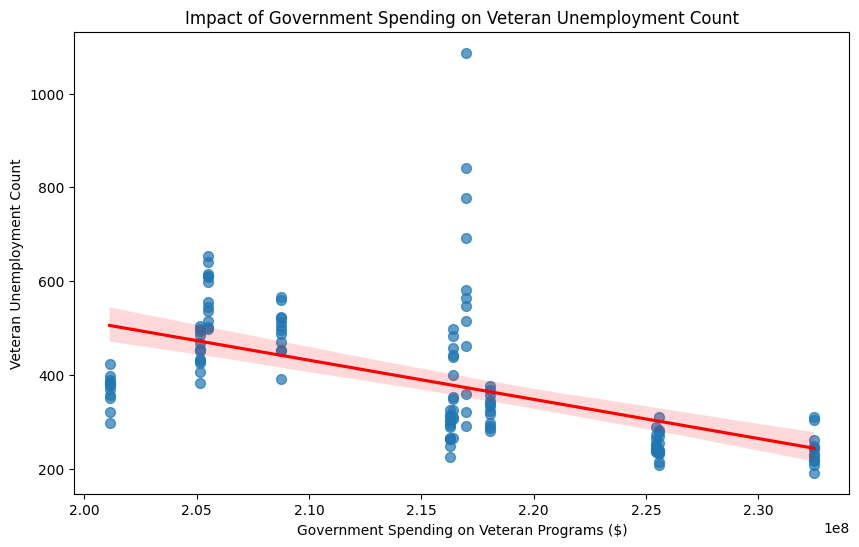

In [150]:
merged_df = vet_employment_stats_df.merge(vet_program_spending_df, left_on='year', right_on='fiscal_year')

plt.figure(figsize=(10, 6))
sns.regplot(data=merged_df, x='total_obligations', y='value', scatter_kws={'s': 50, 'alpha': 0.7}, line_kws={'color': 'red'})
plt.title("Impact of Government Spending on Veteran Unemployment Count")
plt.xlabel("Government Spending on Veteran Programs ($)")
plt.ylabel("Veteran Unemployment Count")
plt.show()


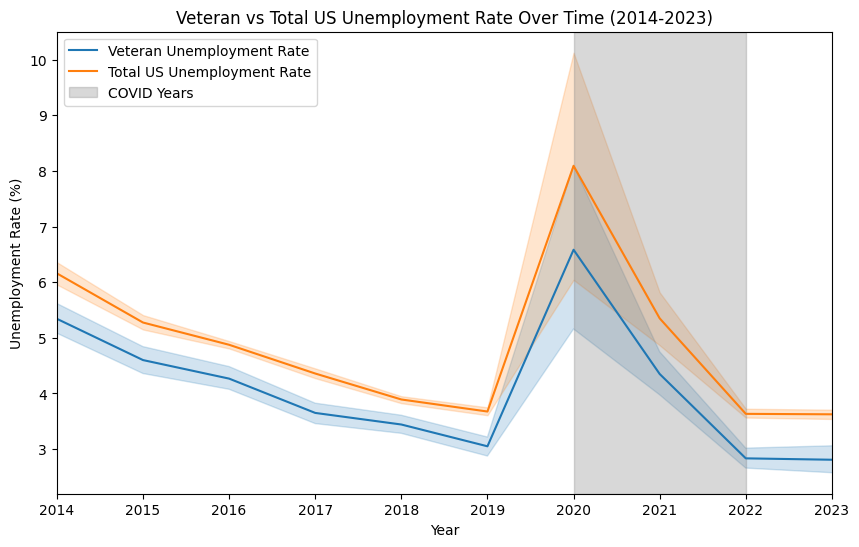

In [151]:
plt.figure(figsize=(10, 6))

sns.lineplot(data=vet_unemployment_rates_df, x='year', y='value', label='Veteran Unemployment Rate')

sns.lineplot(data=unemployment_rate_df, x='Year', y='UNRATE', label='Total US Unemployment Rate')

plt.axvspan(2020, 2022, color='gray', alpha=0.3, label='COVID Years')

plt.title("Veteran vs Total US Unemployment Rate Over Time (2014-2023)")
plt.xlabel("Year")
plt.ylabel("Unemployment Rate (%)")
plt.xlim(2014, 2023)
plt.legend()
plt.show()


In [152]:
#Isolating the data for covid years and averaging unemployment rates for vets and total population during that time compared to 2019
pre_covid_year = 2019
covid_years = [2020, 2021, 2022]

pre_covid_spending = vet_program_spending_df[vet_program_spending_df['fiscal_year'] == pre_covid_year]['total_obligations'].values[0]

covid_spending = vet_program_spending_df[vet_program_spending_df['fiscal_year'].isin(covid_years)]['total_obligations'].mean()

spending_increase_pct = ((covid_spending - pre_covid_spending) / pre_covid_spending) * 100

pre_covid_vet_unemployment = vet_unemployment_rates_df[vet_unemployment_rates_df['year'] == pre_covid_year]['value'].values[0]

covid_vet_unemployment = vet_unemployment_rates_df[vet_unemployment_rates_df['year'].isin(covid_years)]['value'].mean()

vet_unemployment_increase_pct = ((covid_vet_unemployment - pre_covid_vet_unemployment) / pre_covid_vet_unemployment) * 100

spending_increase_pct, vet_unemployment_increase_pct


(1.5569999009236206, 63.888888888888886)

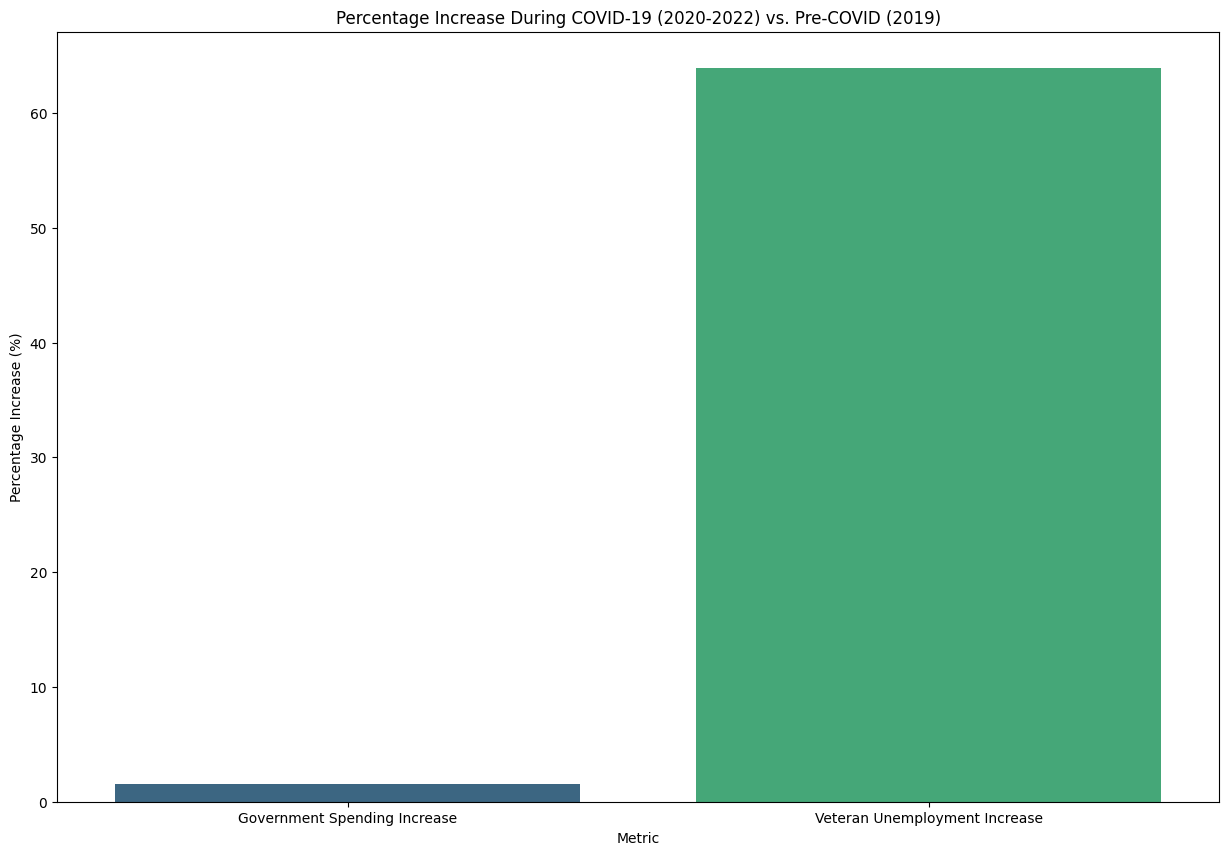

In [153]:
data = {
    "Metric": ["Government Spending Increase", "Veteran Unemployment Increase"],
    "Percentage Increase": [spending_increase_pct, vet_unemployment_increase_pct]
}

increase_df = pd.DataFrame(data)

plt.figure(figsize=(15, 10))
sns.barplot(data=increase_df, x="Metric", y="Percentage Increase", palette="viridis")
plt.title("Percentage Increase During COVID-19 (2020-2022) vs. Pre-COVID (2019)")
plt.ylabel("Percentage Increase (%)")
plt.show()


In [154]:
merged_df = unemployment_rate_df.merge(vet_program_spending_df, left_on='Year', right_on='fiscal_year')

fig = px.treemap(
    merged_df,
    path=["Year"],
    values="total_obligations",
    color="UNRATE",
    color_continuous_scale="Viridis",
    title="Government Spending on Veteran Programs by Year and Unemployment Rate"
)

fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))
fig.update_coloraxes(colorbar_title="Unemployment Rate (%)")

fig.show()


## Visualization Analysis
The scatter plot with a trendline explores how government spending impacts veteran unemployment. The trendline’s negative slope suggests that increased spending is associated with lower veteran unemployment, hinting that investments in veteran programs may help reduce unemployment levels. However, the spread of data points around the trendline shows some variability, indicating that while spending has a positive effect, other factors also influence veteran employment outcomes.

In the bar plot, we see the percentage increase in government spending on veteran programs and veteran unemployment rates during COVID-19 (2020-2022) compared to 2019. The chart reveals a rise in both, with veteran unemployment rates increasing much more sharply than spending. This points to the heightened need for support, as economic disruptions significantly impacted veterans. It also suggests that while the government did help, it the impact of COVID on veteran employment was still a net negative compared to the rise in unemployment.

The line plot shows acomparison of veteran unemployment rates to the total US unemployment rate from 2014 to 2023. During COVID-19, both rates spiked, but veteran unemployment saw a sharper rise and a slower recovery. This trend implies that veterans may face disproportionate challenges in the job market, even as the economy rebounded. The gap between veteran and total unemployment rates highlights these unique employment difficulties, pointing to a need for more targeted support to address the factors affecting veterans’ employment.

Finally, the treemap visualization gives a year-by-year look at how government spending on veteran programs is impacted with the overall US unemployment rate. Here the tile size reflects spending levels, while color intensity shows the unemployment rate. This allows for comparision and to see if the total unemployment rate impacts sending. During the COVID years (2020-2022), larger, darker-colored tiles suggest an uptick in both spending and unemployment, indicating that high unemployment may drive increased veteran support. This year-on-year shows funding strategies change based on economic condition trends.








## Resources and References
*What resources and references have you used for this project?*
📝 <!-- Answer Below -->

In [156]:
# ⚠️ Make sure you run this cell at the end of your notebook before every submission!
!jupyter nbconvert --to python source.ipynb

[NbConvertApp] Converting notebook source.ipynb to python
[NbConvertApp] Writing 18786 bytes to source.py
